# Convolutional Neural Networks with Keras

## [Scientific Computing with Python](http://scicompy.yoavram.com)
## Yoav Ram

In this session we will understand:
- what automatic differentiation is and how it is used to calculate gradients in neural netowrks
- what are convolutions and how they are used to process digital signals
- how convolutional neural networks are used to analyze images
- how to use Keras as a high-level neural networks library

In [95]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import autograd.numpy as anp
import autograd
import seaborn as sns
import pickle
from scipy.signal import convolve
import scipy.misc

import keras
print('Keras', keras.__version__)
from keras import backend as K
print('GPU:', K.tensorflow_backend._get_available_gpus())

def display_image(im, ax=None):
    if ax is None:
        fig, ax = plt.subplots()
    ax.imshow(im, cmap='gray_r')
    ax.set_xticks([])
    ax.set_yticks([])

Keras 2.2.4
GPU: []


# Automatic Differentiation

Before we start talking about convolutional neural networks, we need to talk about [*automatic differentiation*](https://en.wikipedia.org/wiki/Automatic_differentiation).

Given a computer-function `f(x)` that computes the math-function $f(x)$, **automatic differentiation** is an algorithm that produces the computer-function `df(x)` which computes the math-function $\frac{d}{dx}f(x)$.

![](https://upload.wikimedia.org/wikipedia/commons/3/3c/AutomaticDifferentiationNutshell.png)

This can accomplished when all operations made by `f(x)` are differentiable in the sense that their derivative can be computed.
If all such operations are differentiable, then `df(x)` can be produced by applying the chain-rule, similar to *back-propagation*.

There are different ways to implement automatic differentiation, but the idea is the same.
In Python, automatic differentiation is implemented by several packages, but we are going to use the [AutoGrad](https://github.com/HIPS/autograd) package which is specifically designed for use with NumPy in neural network applications (`conda install autograd -c conda-forge`)

We won't actually need to implement `back_propagation(...)`, but rather, we will use [AutoGrad](https://github.com/HIPS/autograd/blob/master/docs/tutorial.md) to calculate the gradients of our loss function (`conda install autograd`).

## Example: logistic function

`logistic(x)` is the logistic funciton:
$$
\text{logistic}(x) = \frac{1}{1+e^{-x}}
$$

In [11]:
def logistic(x):
    return 1/(1 + anp.exp(-x)) # note we use autograd.numpy instead of numpy

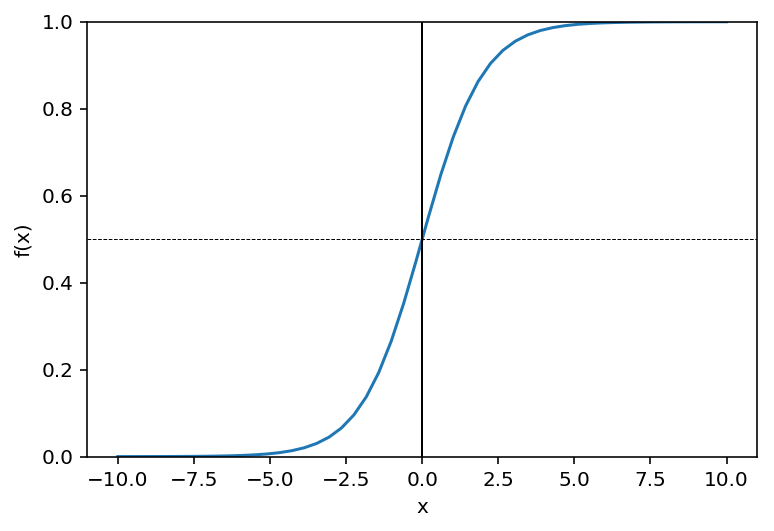

In [30]:
x = np.linspace(-10, 10)
z = logistic(x)

plt.plot(x, z)
# plt.axhline(0, color='k')
plt.axvline(0, color='k', lw=1)
plt.axhline(0.5, color='k', ls='--', lw=0.5)
plt.xlabel('x')
plt.ylabel('f(x)')
plt.ylim(0, 1);

We now calculate and plot the gradient of `logistic(x)` w.r.t `x`.

In [27]:
dlogistic = autograd.elementwise_grad(logistic)
dlogistic

<function autograd.wrap_util.unary_to_nary.<locals>.nary_operator.<locals>.nary_f(*args, **kwargs)>

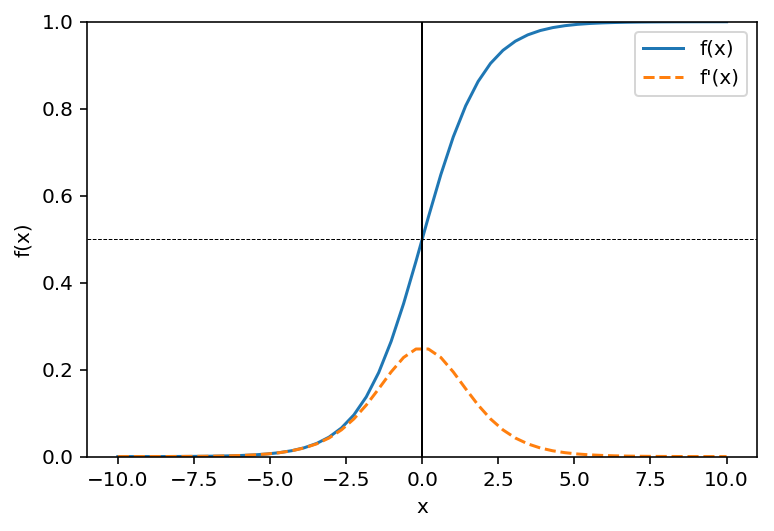

In [31]:
dz = dlogistic(x)

plt.plot(x, z, label="f(x)")
plt.plot(x, dz, '--', label="f'(x)")
plt.axvline(0, color='k', lw=1)
plt.axhline(0.5, color='k', ls='--', lw=0.5)
plt.xlabel('x')
plt.ylabel('f(x)')
plt.ylim(0, 1)
plt.legend();

## Example: feed forward network

Automatic differentiation also works well through a neural network. 
Indeed, all major deep learning frameworks use automatic differentiation to calculate gradients.

For example, for this one-hidden layer network with a logistic regression output (i.e. binary classifier):

$$
\mathbf{Z_1} = \mathbf{X_1} \cdot  \mathbf{W_1} \\
\mathbf{X_2} = ReLU(\mathbf{Z_1}) \\
\mathbf{Z_2} = \mathbf{X_2} \cdot \mathbf{W_2} \\
\mathbf{\widehat Y} = logistic(\mathbf{Z_2}) \\
\mathbf{J} = - \sum_{j=1}^{nsamples}{ y_{j} \log{\widehat y_{j}} + (1-y_{j}) \log{(1 - \widehat y_{j})} }
$$

The loss function is:

In [123]:
def loss(Ws, X, Y):
    X1 = X
    W1, W2 = Ws
    # hidden layer
    Z1 = X1 @ W1 
    X2 = anp.maximum(Z1, 0) 
    # readout layer (logistic)
    Z2 = X2 @ W2 
    Yhat = logistic(Z2)
    # cross entropy
    loglik = Y * anp.log(Yhat) + (1 - Y) * anp.log(1-Yhat)
    return -loglik.mean()

And we can get the back-propagation using AutoGrad:

In [121]:
back_propagation = elementwise_grad(loss, argnum=0)

In [122]:
def gradient_check(Ws, X, Y, Δ=1e-5):
    dWs = back_propagation(Ws, X, Y)
    Ws_ = [W.copy() for W in Ws]

    for i, (W_, dW_) in enumerate(zip(Ws_, dWs)):
        print('W{}'.format(i+1))
        for i in range(W_.shape[0]):
            for j in range(W_.shape[1]):
                dw = dW_[i, j]
                W_[i,j] += Δ
                loss1 = loss(Ws_, X, Y)
                W_[i,j] -= 2*Δ
                loss2 = loss(Ws_, X, Y)
                W_[i,j] += Δ
                dw_ = (loss1 - loss2) / (2 * Δ)
                rel_error = abs(dw - dw_) / abs(dw + dw_)
                if not np.isclose(dw_, dw):
                    print(i, j, dw, dw_, rel_error)

X = np.random.uniform(size=(1000, 100))
Y = (np.random.uniform(size=1000) < 0.3).astype(int)
nhidden = 10
W1 = np.random.normal(size=(100, 10))
W2 = np.random.normal(size=(10, 1))
Ws = [W1, W2]
gradient_check(Ws, X, Y)                    

W1
W2


# Convolutions

Next up, we are going to discuss convolutions as they are used in analysis of structured data and specifically in signal and image analysis.
Note that convolutions have broader definitions and more uses, but for our purposes it is much simpler to consider them as [**local filters**](https://en.wikipedia.org/wiki/Digital_image_processing#Filtering) or **local weighted averaging**.

Given a data array $\mathbf{x}=(x_1, \ldots, x_n)$ and a weights array $\mathbf{y}=(y_{-m}, \ldots, y_0, \ldots, y_m)$ (called a *kernel*), the $i$-th entry of the convolution $\mathbf{x} \ast \mathbf{y}$ of $\mathbf{x}$ by $\mathbf{y}$ is calculated by extracting the $2m+1$ entries of $\mathbf{x}$ around entry $i$, multiplying the extracted entries element-wise with $\mathbf{y}$, and summing the products:

$$
(\mathbf{x} \ast \mathbf{y})_i = \sum_{j=0}^{2m}{y_j \cdot x_{i-m+j}}
$$

## Exercise: Convolution

Implement a 1D convolution which accepts a long 1D data array `x` and a short 1D kernel array `y` and returns the convolution of `x` by `y`.

If you are worried about the values at the start and end of the array, you can pad `x` using `np.pad`.

In [142]:
def myconvolve(x, y):
    pass

In [143]:
x = np.arange(10, dtype=int)
print(x)
y = np.ones(3, dtype=int)
print(y)

[0 1 2 3 4 5 6 7 8 9]
[1 1 1]


In [144]:
myconvolve(x, y)

[1, 3, 6, 9, 12, 15, 18, 21, 24, 17]

Compare with SciPy's `convolve` function:

In [74]:
convolve(x, y, mode='same')

array([ 1,  3,  6,  9, 12, 15, 18, 21, 24, 17])

Note that SciPy's version uses smart optimization techniques (see `method` keyword argument), so it is much faster:

In [75]:
x = np.arange(1000, dtype=float)
y = np.ones(7, dtype=float)
%timeit myconvolve(x, y)
%timeit convolve(x, y, mode='same')

3.21 ms ± 131 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
16.2 µs ± 1.42 µs per loop (mean ± std. dev. of 7 runs, 100000 loops each)


The `mode` keyword argument decides how to deal with the edges - pad with zeros (`full`), pad and trim to original size (`same`), or remove edges (`valid`).
This is a technical detail, but since the output arrays will of different sizes, it's important to be aware of the difference between the modes.

# 2D convolutions

Convolutions are very common in signal and image analysis because they are rather efficient and can represent many algorithms in which a pixel/data point is replaced by a weighted average of its neighbor pixels.

See this [animation of convolutions](http://cs231n.github.io/assets/conv-demo/index.html).

Here are some Examples

#### Blur/Smooth

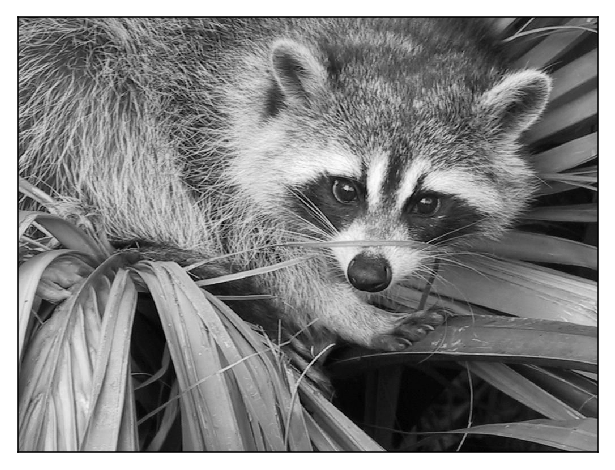

In [96]:
face = ~scipy.misc.face(gray=True)
display_image(face)

[[0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01]
 [0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01]
 [0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01]
 [0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01]
 [0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01]
 [0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01]
 [0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01]
 [0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01]
 [0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01]
 [0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01]]


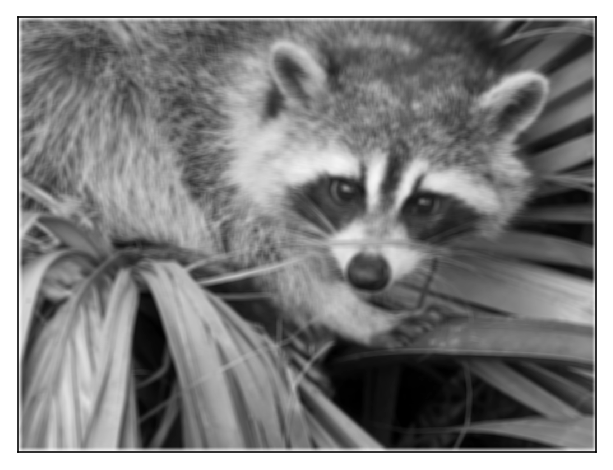

In [81]:
kernel = np.ones((10,10))
kernel /= kernel.sum()
display_image(convolve(face, kernel))
print(kernel)

#### Gaussian denoising

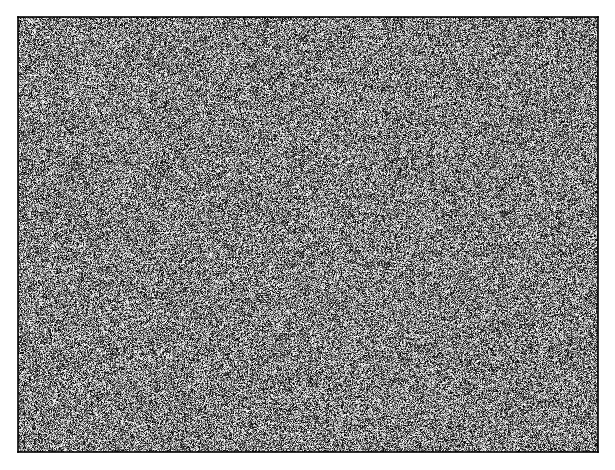

In [82]:
noise = np.random.randint(0, 255, size=face.shape)
display_image(noise)

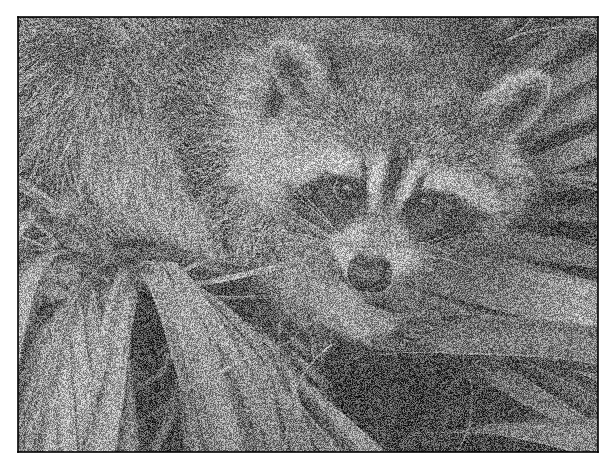

In [83]:
display_image(face + noise)

[[ 1.  4.  6.  4.  1.]
 [ 4.  6. 24.  6.  4.]
 [ 6. 24. 36. 24. 36.]
 [ 4.  6. 24.  6.  4.]
 [ 1.  4.  6.  4.  1.]]


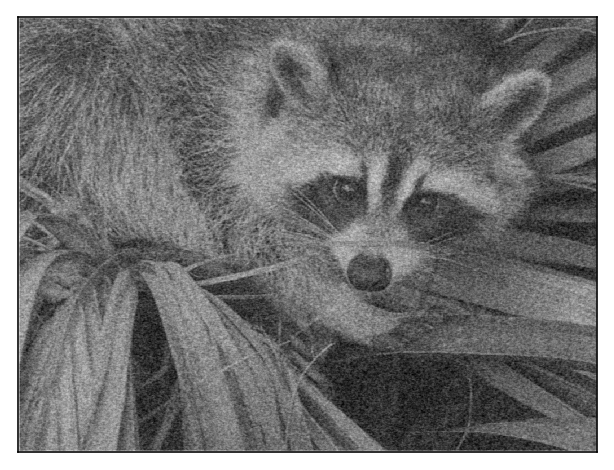

In [84]:
kernel = np.array([[1, 4, 6, 4, 1], [4, 6, 24, 6, 4], [6, 24, 36, 24, 36], [4, 6, 24, 6, 4], [1, 4, 6, 4, 1]], dtype=float)
print(kernel)
kernel /= kernel.sum()
display_image(convolve(face + noise, kernel))

#### Sharpen

[[ 0. -1.  0.]
 [-1.  5. -1.]
 [ 0. -1.  0.]]


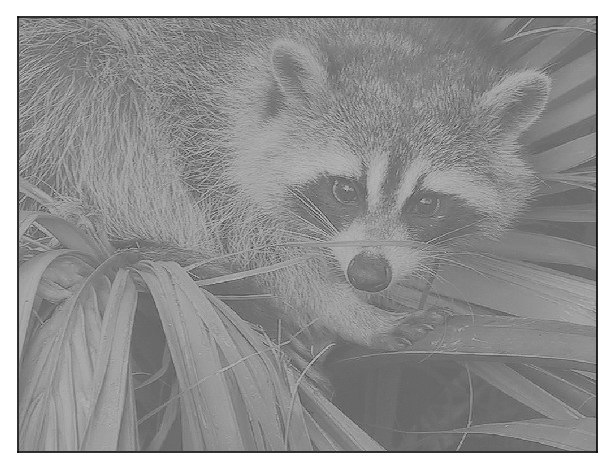

In [85]:
kernel = np.zeros((3, 3))
kernel[0,1] = kernel[1,0] = kernel[2,1] = kernel[1,2] = -1
kernel[1,1] = 5
display_image(convolve(face, kernel))
print(kernel)

#### Edge detection

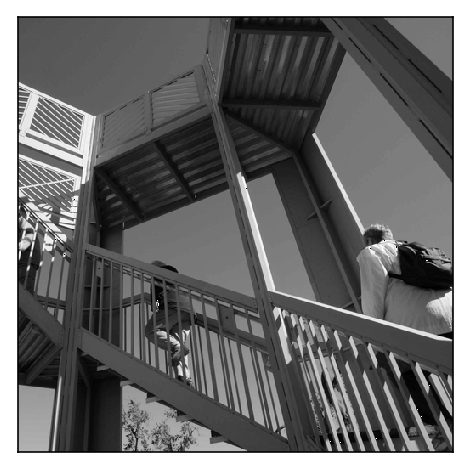

In [86]:
ascent = ~scipy.misc.ascent()
display_image(ascent)

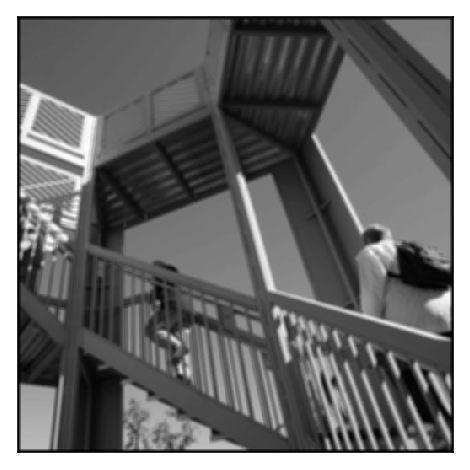

In [87]:
smoothed = convolve(ascent, np.ones((5, 5))/25)
display_image(smoothed)

[[-1. -1. -1.]
 [-1.  8. -1.]
 [-1. -1. -1.]]


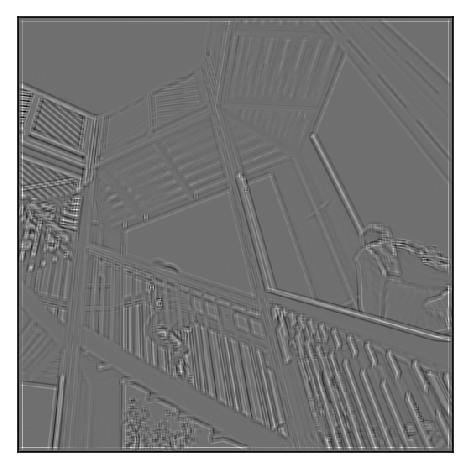

In [88]:
kernel = -np.ones((3, 3))
# kernel[0,1] = kernel[1,0] = kernel[2,1] = kernel[1,2] = -1
kernel[1,1] = 8
display_image(convolve(smoothed, kernel))
print(kernel)

#### Smoothing + edge detection

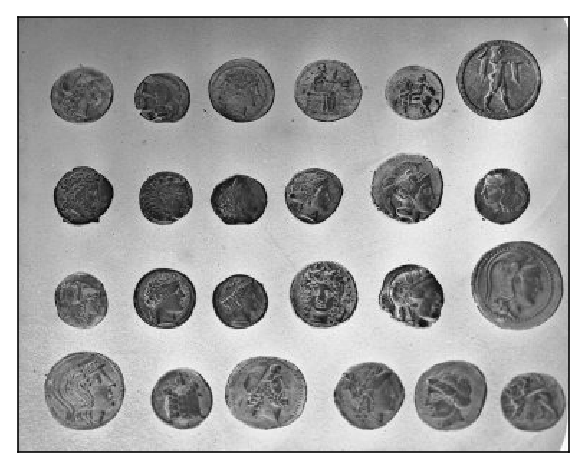

In [89]:
from skimage.data import coins
coins = coins()
display_image(coins)

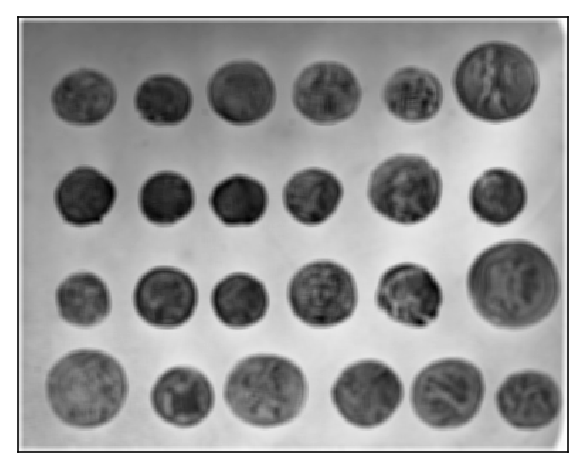

In [90]:
smoothed = convolve(coins, np.ones((5, 5), dtype=float)/25)
display_image(smoothed)

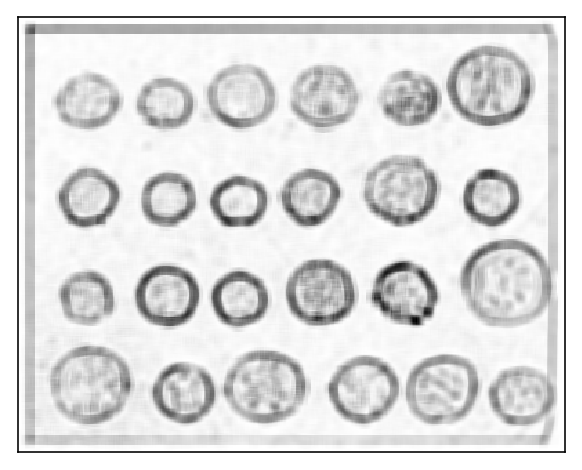

In [92]:
kernel = -np.ones((3, 3))
kernel[1,1] = -kernel.sum() - 1
edges = np.maximum(convolve(smoothed, kernel), 0) # ReLU
edges = convolve(edges, np.ones((7, 7), dtype=float)/49)
display_image(edges)

## Exercise: Gradient detection

Write a kernel for gradient detection.
A [gradient in a 2D array](https://en.wikipedia.org/wiki/Image_gradient) (e.g. image) is defined as the directional change in the intensity.
For pixel $x_{i,j}$ at row $i$ and column $j$, the gradient at the horizontal direction $\nabla_{i,j}^h$ is 

$$
\nabla_{i,j}^h = x_{i,j+1}-x_{i,j-1}
$$

and the vertical gradient $\nabla_{i,j}^v$ can be similarly calculated by shifting $i$.

Calculate the horizontal gradient.

In [93]:
def horizontal_gradient(im):
    pass

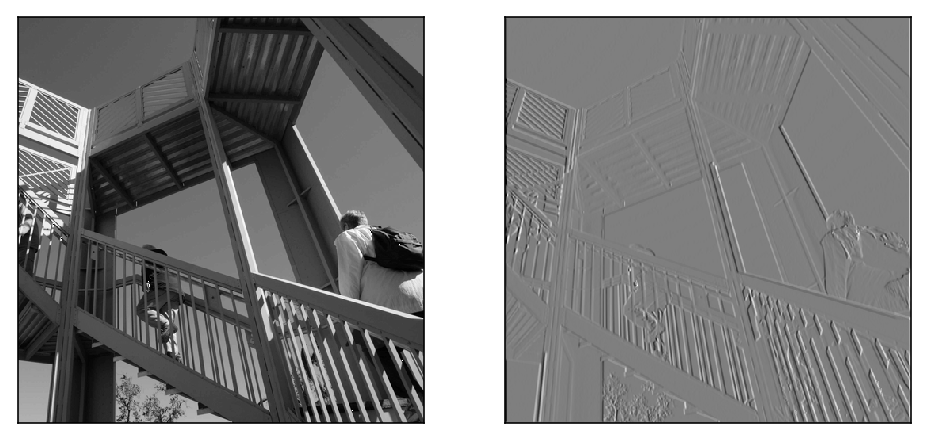

In [97]:
gradient = horizontal_gradient(ascent)
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
display_image(ascent, ax=axes[0])
display_image(gradient, ax=axes[1])

# Keras

[Keras](https://keras.io/) is a high-level neural networks API, written in Python and capable of running on top of TensorFlow, [CNTK](https://docs.microsoft.com/en-us/cognitive-toolkit/) (MS deep learning package), or [Theano](http://www.deeplearning.net/software/theano/).

The main benefit is that it *allows for easy and fast prototyping*.

Note that as of now, Keras cannot be installed with Python 3.7.

We use Keras' datasets module to load the data:

In [98]:
(X_train, Y_train), (X_test, Y_test) = keras.datasets.mnist.load_data()
nsamples, width, height = X_train.shape
nfeatures = width * height
X_train = X_train/255
X_test = X_test/255

That last step of normalizing the data to be floats between 0 and 1 (it's originally betweeen 0 and 255 in integers) is crucial, although you could probably instead just change how the weights of the network are initialized.

Now let's do one-hot encoding of the labels:

In [99]:
Y_train = keras.utils.to_categorical(Y_train)
Y_test = keras.utils.to_categorical(Y_test)
ncats = Y_test.shape[1]

The images are 1D arrays of length 28x28=784; the labels are one-hot encodes numbers between 0 and 9:

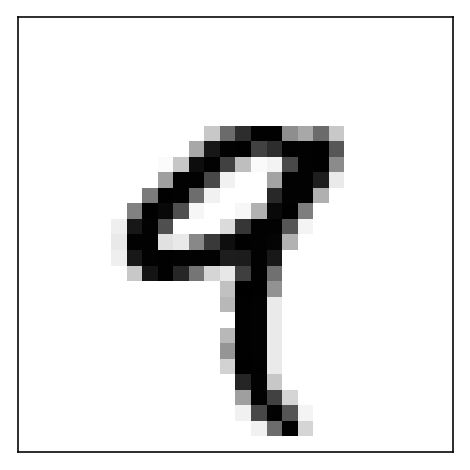

In [100]:
display_image(X_train[4])

# Multilayer Convolutional Network

We build a multilayer convolutional neuron network.

In a convolutional neural network we replace some of the fully-connected layers with convolutional layers in which we apply several convolutional filters to the input.

A convolution is very efficient:
- **parameter sharing**: parameters of the convolution are shared among all pixels.
- **translation invariant** the convolution is robust to the position of a feature inside the image.

We'll start by implementing a two-layer network in which the first layer is a convolutional layer and the second layer is a fully-connected softmax layer:

$$
\mathbf{Z_1} = \mathbf{X_1} \ast \mathbf{W_1} + b_1 \\
\mathbf{X_2} = pool({\tanh{(\mathbf{Z_1})}}) \\
\mathbf{Z_2} = \mathbf{X_2} \cdot \mathbf{W_2} + b_2 \\
\mathbf{\widehat Y} = softmax(\mathbf{Z_2})
$$

![](http://deeplearning.net/tutorial/_images/mylenet.png)

## Keras model

We start by creating a Keras model, the neural network, to which we will add the different layers.
This model is a `Sequential` model, that is, data flows sequentially from one layer to the next.

In [124]:
model = keras.models.Sequential()

## Input layer

In the CNN model our data (the layers) is no longer 2D (`(nsamples, nfeatures)`).
It is now a 4D tensor with shape `(nsamples, width, height, nchannels)`, where `nchannels` can be, for example, 3 for a color image, or 10 for the output of 10 filters.

Note that the first layer in any model must have the `input_shape` parameter that defines the shape of a single input sample. 
Other layers can infer their shape from the previous layers (sequential model!)

The data arrives with just `(nsamples, width, height)` so we have to reshape it to `(nsamples, width, height, 1)` for a single channel (greyscale).

In [125]:
model.add(
    keras.layers.Reshape(target_shape=(width, height, 1), 
                         input_shape=(width, height)))

## First convolutional layer

The first convolutional layer is generated by a convolution with 1 input channel, 32 output channgels, and 5x5 kernels.

The convolution computes 32 features of 5x5 patches; it returns a tensor with shape `(-1, 28, 28, 32)`.

We then apply a ReLU activation function $f(x)=max(0,x)$.

In [126]:
model.add(
    keras.layers.Conv2D(32, (5, 5)))
model.add(
    keras.layers.ReLU())

## Pooling

The new element here is the $pool$ function, which applies **pooling** - the combination of several neurons/pixels into a single one.

We will use a common pooling approach called *2x2 max pooling* in which every 2x2 square of pixels is replaced by its maximal value.

![](https://upload.wikimedia.org/wikipedia/commons/e/e9/Max_pooling.png)

Pooling adds another non-linear component, reduces the size of the layers, and thus the number of paramters, and reduces over-fitting by approximating the location of feautures.

Since thd activation function operates element-wise without impacting the shape, the output of the activation and pooling has shape `(-1, 14, 14, 32)`.

In [127]:
model.add(
    keras.layers.MaxPool2D())

## Second convolutional layer

We add another convolution + pooling layer, the 2nd layer will have 64 features. The input has 32 channels (from the previous 32 features) but he data arrays are smaller (14x14) due to the previous pooling:

In [128]:
model.add(
    keras.layers.Conv2D(64, (5, 5)))
model.add(
    keras.layers.ReLU())
model.add(
    keras.layers.MaxPool2D())

The data is now is shape `(-1, 7, 7, 64)`.

## Fully connected layer

Now we add a fully-connected layer with 1024 neurons. This is done by matrix multiplication with a 7x7x64-by-1024 weight matrix, just like we did with FFN.

But first we need to flatten the input from 7x7x64 to 3136.

In [129]:
model.add(
    keras.layers.Flatten())
model.add(
    keras.layers.Dense(1024))
model.add(
    keras.layers.ReLU())

## Dropout layer

We apply a dropout to reduce overfitting: the dropout stochasticly removes neurons (outputs of the previous layer) and automatically scales the neurons it retained so that their expected sum remains unchanged.

In [130]:
model.add(
    keras.layers.Dropout(0.5))

## Readout layer

We add a Softmax regression layer, similar to the previous, simpler example, by adding a dense layer with softmax activation.

In [131]:
model.add(
    keras.layers.Dense(ncats))
model.add(
    keras.layers.Softmax())

Now let's visualize the model.

This won't work if you don't have pydot (`pip install pydot`) [Graphviz](https://graphviz.org) installed, the latter requires software installation. So skip it...

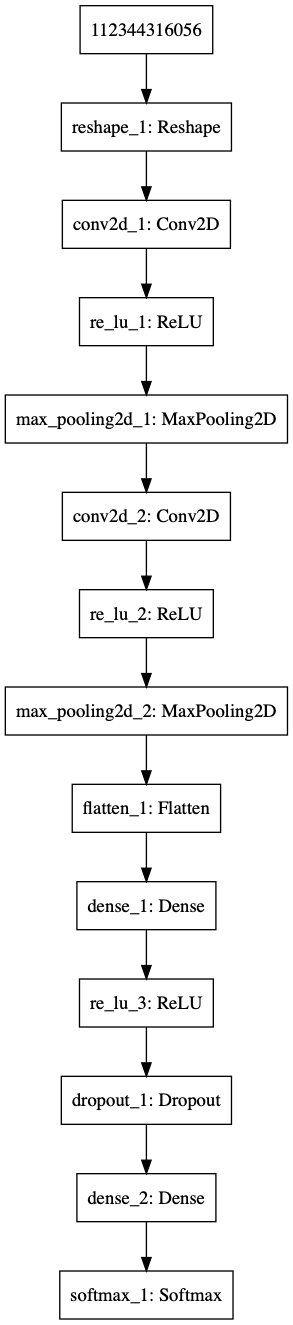

In [132]:
keras.utils.plot_model(model, to_file='tmp.png')
keras.preprocessing.image.load_img('tmp.png')

In [133]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_1 (Reshape)          (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 32)        832       
_________________________________________________________________
re_lu_1 (ReLU)               (None, 24, 24, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 64)          51264     
_________________________________________________________________
re_lu_2 (ReLU)               (None, 8, 8, 64)          0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 64)          0         
__________

## Training

To train the model we need to define the loss function. We'll use the same cross entropy function as before. We also use the same measure for accuracy - we predict the most likelihood class and check that it is the correct label.

In [134]:
model.compile(
    loss=keras.losses.categorical_crossentropy,
    optimizer=keras.optimizers.Adam(), 
    metrics=[keras.metrics.categorical_accuracy]
)

The actual training takes about 6-7 mins on a MacBook Pro 13" 2016 with max specs, or about 1 min on AWS g3.4xlarge virtual machine with Tesla M60 GPU, reaching accuracy >99% on the validation set.

In [14]:
history = model.fit(x=X_train, y=Y_train, batch_size=50, epochs=5, 
    validation_data=(X_test, Y_test),
).history

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 67s 1ms/step - loss: 0.1323 - acc: 0.9584 - val_loss: 0.0458 - val_acc: 0.9844
Epoch 2/5
60000/60000 [==============================] - 69s 1ms/step - loss: 0.0450 - acc: 0.9861 - val_loss: 0.0325 - val_acc: 0.9893
Epoch 3/5
60000/60000 [==============================] - 65s 1ms/step - loss: 0.0315 - acc: 0.9904 - val_loss: 0.0242 - val_acc: 0.9916
Epoch 4/5
60000/60000 [==============================] - 68s 1ms/step - loss: 0.0246 - acc: 0.9923 - val_loss: 0.0246 - val_acc: 0.9914
Epoch 5/5
60000/60000 [==============================] - 63s 1ms/step - loss: 0.0192 - acc: 0.9940 - val_loss: 0.0281 - val_acc: 0.9920


Amazingly, the neural network very quickly achieves a better accuracy than the previous approach - after one epoch the validation accuracy is > 0.98.
The validation accuracy then fluctuates for a long time around 0.99.

Save the model and the history:

In [ ]:
model.save('../data/keras_cnn_model.h5')
with open("../data/keras_cnn_history.p", "wb") as f:
    pickle.dump(history, f)

Load model and history (ignore the warning about the optimizer state):

In [136]:
model = keras.models.load_model('../data/keras_cnn_model.h5')
with open("../data/keras_cnn_history.p", "rb") as f:
    history = pickle.load(f)

/Users/yoavram/miniconda3/envs/SciComPy/lib/python3.6/site-packages/keras/engine/saving.py:327: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


Plot history:

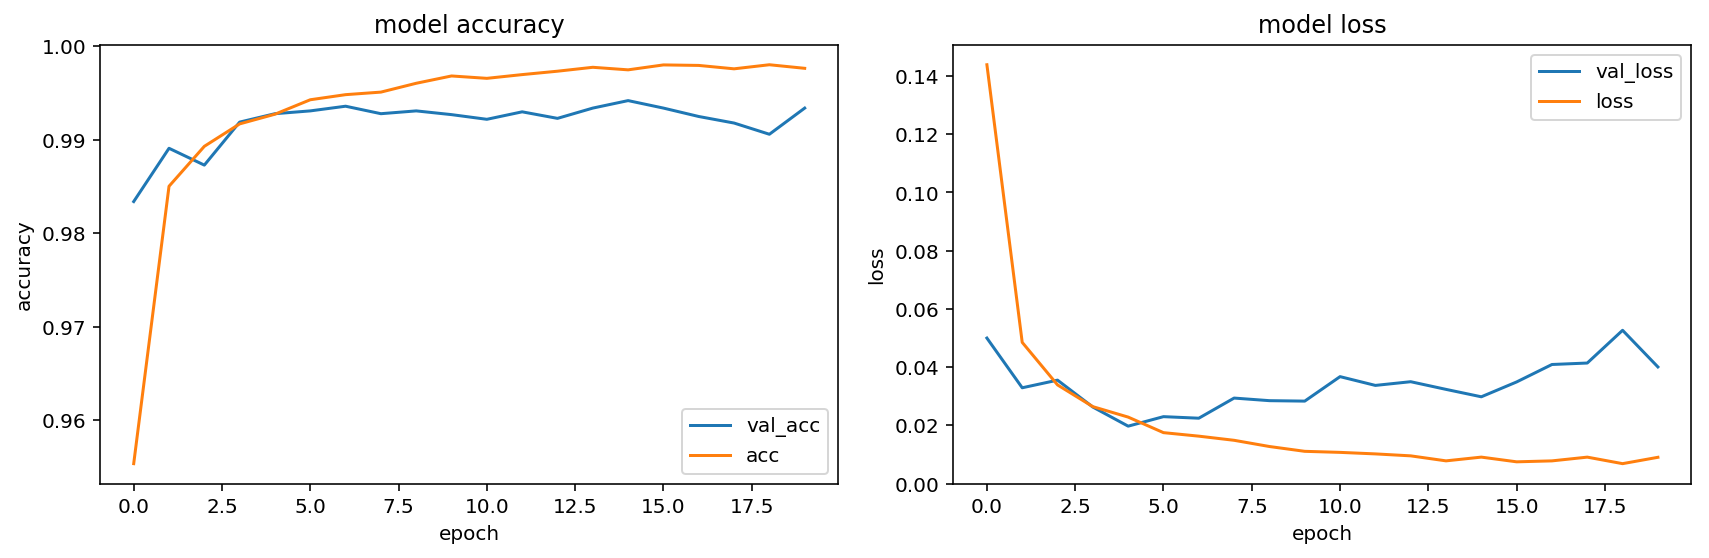

In [138]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharex=True)

ax = axes[0]
for k,v in history.items():
    if 'acc' in k:
        ax.plot(v, label=k)
ax.set(
    title='model accuracy',
    ylabel='accuracy',
    xlabel='epoch',
)
ax.legend()

ax = axes[1]
for k,v in history.items():
    if 'loss' in k:
        ax.plot(v, label=k)
ax.set(
    title='model loss',
    ylabel='loss',
    xlabel='epoch',
)
ax.legend()
    
fig.tight_layout()

We can also visualize the network weights using [Quiver](https://keplr-io.github.io/quiver/).

# References

- [Keras examples](https://github.com/keras-team/keras/tree/master/examples)
- [Google colaboratory](http://colab.research.google.com) allows you to run Jupyter notebooks in the cloud on a machine with a GPU. Just change the runtime to Python3+GPU.

# Colophon
This notebook was written by [Yoav Ram](http://python.yoavram.com) and is part of the [_Scientific Computing with Python_](https://scicompy.yoavram.com/) course at IDC Herzliya.

The notebook was written using [Python](http://python.org/) 3.6.5.
Dependencies listed in [environment.yml](../environment.yml).

This work is licensed under a CC BY-NC-SA 4.0 International License.

![Python logo](https://www.python.org/static/community_logos/python-logo.png)